### Health Data Set

In [ ]:
import pandas as pd

file_2011 = "/Users/parulnagar/Projects/2024_25/visual analytics/summative/2011/General_health.xls"
df_health_2011_raw = pd.read_excel(file_2011, sheet_name="QS302EW_Numbers", skiprows=10)

df_health_2011_raw = df_health_2011_raw[df_health_2011_raw['Area code'].astype(str).str.match(r"E06|E07|E08|E09|W06|W07|W08|W09")]

# Select and clean columns 
df_health_2011 = df_health_2011_raw[[
    'Area code', 'Area name',
    'Very good health', 'Good health', 'Fair health',
    'Bad health', 'Very bad health'
]].copy()

# Remove commas and convert to integers 
health_cols = df_health_2011.columns[2:]
for col in health_cols:
    df_health_2011[col] = (
        df_health_2011[col].astype(str)
        .str.replace(",", "", regex=False)
        .replace('nan', 0)
        .astype(float)
        .astype(int)
    )

# Reshape to long format 
df_health_2011_long = df_health_2011.melt(
    id_vars=['Area code', 'Area name'],
    value_vars=health_cols,
    var_name='General health (6 categories)',
    value_name='Observation'
)
df_health_2011_long['Year'] = 2011


file_2021 = "/Users/parulnagar/Projects/2024_25/visual analytics/summative/2021/General_health_2021.csv"
df_health_2021_raw = pd.read_csv(file_2021)

# Rename columns to match 2011
df_health_2021_raw = df_health_2021_raw.rename(columns={
    'Lower tier local authorities Code': 'Area code',
    'Lower tier local authorities': 'Area name',
    'General health (6 categories)': 'General health (6 categories)',
    'Observation': 'Observation'
})

# Filter out irrelevant rows 
df_health_2021_raw = df_health_2021_raw[df_health_2021_raw['General health (6 categories)'] != 'Does not apply']

# Convert observation to numeric 
df_health_2021_raw['Observation'] = df_health_2021_raw['Observation'].astype(int)

# Aggregate by LA and health category 
df_health_2021_agg = (
    df_health_2021_raw
    .groupby(['Area code', 'Area name', 'General health (6 categories)'], as_index=False)
    ['Observation'].sum()
)
df_health_2021_agg['Year'] = 2021

df_health_combined = pd.concat([df_health_2011_long, df_health_2021_agg], ignore_index=True)

df_health_combined = df_health_combined.sort_values(by=['Area code', 'Year', 'General health (6 categories)'])

print("Combined shape:", df_health_combined.shape)
print(df_health_combined['Year'].value_counts())
print(df_health_combined.head())

# Save the combined DataFrame to a CSV file
df_health_combined.to_csv('Health_combined_2011_2021.csv')

Combined shape: (3395, 5)
Year
2011    1740
2021    1655
Name: count, dtype: int64
      Area code Area name General health (6 categories)  Observation  Year
1046  E06000001       NaN                    Bad health         5789  2011
698   E06000001       NaN                   Fair health        14607  2011
350   E06000001       NaN                   Good health        30117  2011
1394  E06000001       NaN               Very bad health         1699  2011
2     E06000001       NaN              Very good health        39816  2011


/Users/parulnagar/.pyenv/versions/3.12.7/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: Health_Projections_2011_2021.csv


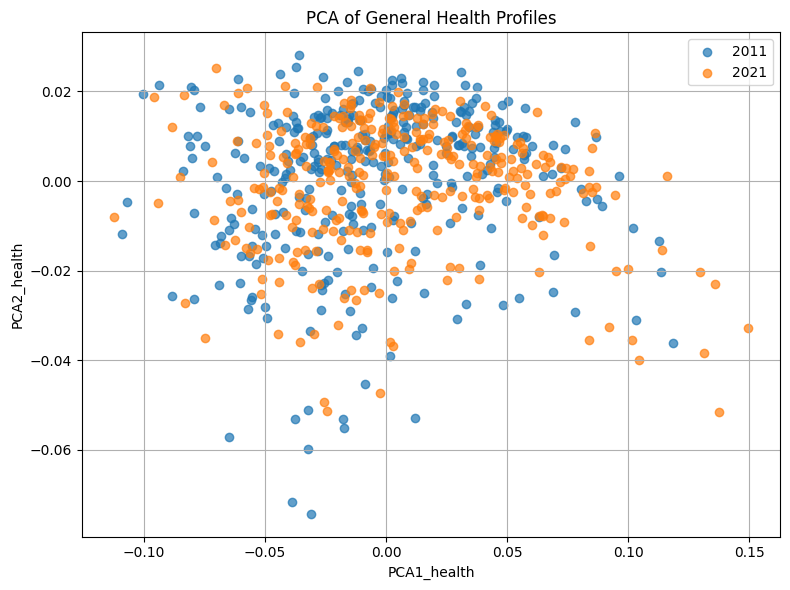

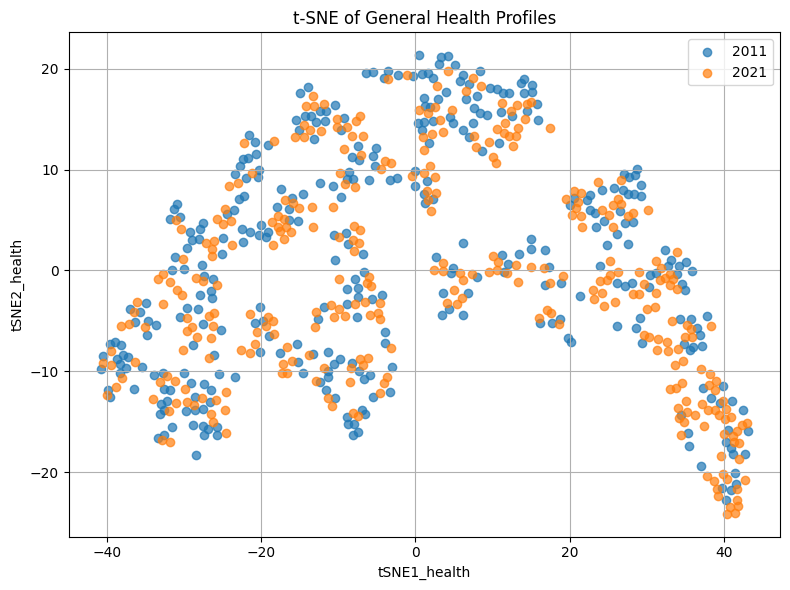

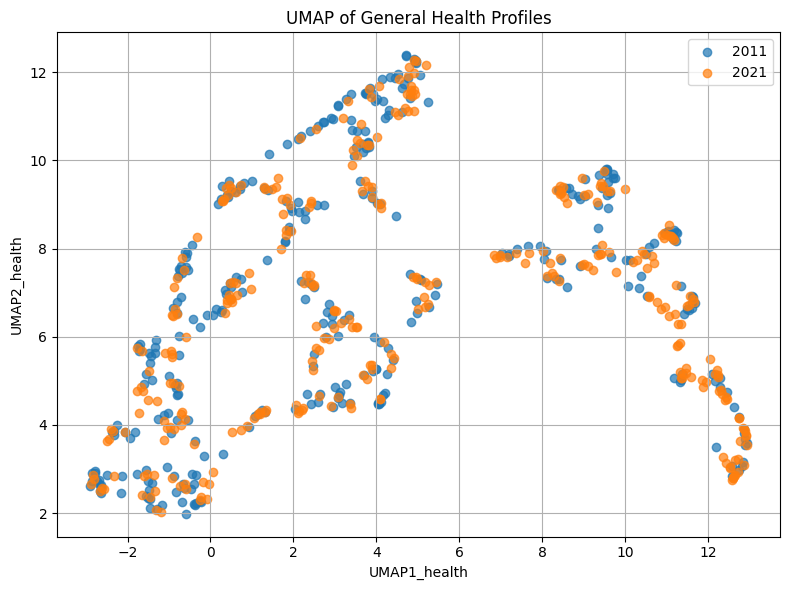

In [148]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

df_health = pd.read_csv('Health_combined_2011_2021.csv')

health_wide = df_health.pivot_table(
    index=['Area code', 'Year'],
    columns='General health (6 categories)',
    values='Observation',
    aggfunc='sum'
).reset_index()

# Normalize health counts to proportions (row-wise)
health_cols = health_wide.columns.difference(['Area code', 'Area name', 'Year'])
health_wide[health_cols] = health_wide[health_cols].div(health_wide[health_cols].sum(axis=1), axis=0)

# Fill missing values with 0 
health_wide[health_cols] = health_wide[health_cols].fillna(0)

# Apply PCA
pca = PCA(n_components=2)
health_wide[['PCA1_health', 'PCA2_health']] = pca.fit_transform(health_wide[health_cols])

# Apply t-SNE
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(health_wide[health_cols])
health_wide['tSNE1_health'], health_wide['tSNE2_health'] = tsne_result[:, 0], tsne_result[:, 1]

# Apply UMAP
umap_result = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(health_wide[health_cols])
health_wide['UMAP1_health'], health_wide['UMAP2_health'] = umap_result[:, 0], umap_result[:, 1]

# Save output with projections
health_wide.to_csv("Health_Projections_2011_2021.csv", index=False)
print("Saved: Health_Projections_2011_2021.csv")

def plot_embedding(df, x, y, title):
    plt.figure(figsize=(8, 6))
    for year in sorted(df['Year'].unique()):
        subset = df[df['Year'] == year]
        plt.scatter(subset[x], subset[y], label=str(year), alpha=0.7)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_embedding(health_wide, 'PCA1_health', 'PCA2_health', 'PCA of General Health Profiles')
plot_embedding(health_wide, 'tSNE1_health', 'tSNE2_health', 't-SNE of General Health Profiles')
plot_embedding(health_wide, 'UMAP1_health', 'UMAP2_health', 'UMAP of General Health Profiles')


In [157]:
df = pd.read_csv("Health_projections_2011_2021.csv")

# Pivot to wide format for delta maps and side-by-side bars
df_wide = df.pivot_table(
    index='Area code',
    columns='Year',
    values=['Very good health', 'Good health', 'Fair health', 'Bad health', 'Very bad health'],
    aggfunc='first'
)

# Flatten multi-level columns
df_wide.columns = [f"{col[0]} {col[1]}" for col in df_wide.columns]
df_wide = df_wide.reset_index()

# Save for Tableau
df_wide.to_csv("Health_Proportion_2011_vs_2021.csv", index=False)


### Education DataSet

In [ ]:
import pandas as pd

# Load the dataset for 2011
df_edu_2011 = pd.read_csv('/Users/parulnagar/Projects/2024_25/visual analytics/summative/2011/Highest_level_of_qualification.csv')  

# Renaming columns for clarity and consistency
df_edu_2011 = df_edu_2011.rename(columns={
    'geography': 'Area name',
    'geography code': 'Area code',
    'date': 'Year',
    'Qualification: All categories: Highest level of qualification; measures: Value': 'Total',
    'Qualification: No qualifications; measures: Value': 'No qualification',
    'Qualification: Level 1 qualifications; measures: Value': 'Level 1',
    'Qualification: Level 2 qualifications; measures: Value': 'Level 2',
    'Qualification: Apprenticeship; measures: Value': 'Apprenticeship',
    'Qualification: Level 3 qualifications; measures: Value': 'Level 3',
    'Qualification: Level 4 qualifications and above; measures: Value': 'Level 4+',
    'Qualification: Other qualifications; measures: Value': 'Other'
})

# Melt into long format 
df_edu_long = pd.melt(df_edu_2011,
                      id_vars=['Area code', 'Area name', 'Year'],
                      value_vars=['No qualification', 'Level 1', 'Level 2', 'Apprenticeship', 'Level 3', 'Level 4+', 'Other'],
                      var_name='Qualification level',
                      value_name='Number of persons')

# Preview results 
print(df_edu_long.head())


   Area code       Area name  Year Qualification level  Number of persons
0  E06000005      Darlington  2011    No qualification              21179
1  E06000047   County Durham  2011    No qualification             116948
2  E06000001      Hartlepool  2011    No qualification              22758
3  E06000002   Middlesbrough  2011    No qualification              33002
4  E06000057  Northumberland  2011    No qualification              62584


In [ ]:
import pandas as pd

### Load and clean 2021 education data ###
df_edu_2021 = pd.read_csv("/Users/parulnagar/Projects/2024_25/visual analytics/summative/2021/Highest_level_of_qualification_2021.csv")

# Remove "Does not apply"
df_edu_2021 = df_edu_2021[df_edu_2021['Highest level of qualification (8 categories)'] != 'Does not apply']

# Rename columns to match 2011 dataset
df_edu_2021 = df_edu_2021.rename(columns={
    'Lower Tier Local Authorities Code': 'Area code',
    'Lower Tier Local Authorities': 'Area name',
    'Highest level of qualification (8 categories)': 'Qualification level',
    'Observation': 'Number of persons'
})

#  Standardize the 2021 qualification labels to match 2011 
def standardize_qualification(label):
    label = label.lower()
    if 'no qualification' in label:
        return 'No qualification'
    elif 'level 1' in label:
        return 'Level 1'
    elif 'level 2' in label:
        return 'Level 2'
    elif 'apprenticeship' in label:
        return 'Apprenticeship'
    elif 'level 3' in label:
        return 'Level 3'
    elif 'level 4' in label:
        return 'Level 4+'
    elif 'other' in label:
        return 'Other'
    else:
        return label.strip()

df_edu_2021['Qualification level'] = df_edu_2021['Qualification level'].apply(standardize_qualification)

# Add year column 
df_edu_2021['Year'] = 2021

# Select only required columns 
df_edu_2021 = df_edu_2021[['Area code', 'Area name', 'Year', 'Qualification level', 'Number of persons']]

### Merge with 2011 long-format dataset ###
# Make sure df_edu_long is already defined from your 2011 reshape
df_edu_2011_long = df_edu_long[['Area code', 'Area name', 'Year', 'Qualification level', 'Number of persons']]

# Combine the two datasets 
df_edu_combined = pd.concat([df_edu_2011_long, df_edu_2021], ignore_index=True)

# Save to CSV for Tableau 
df_edu_combined.to_csv("Highest_level_of_qualification_2011_2021.csv", index=False)

print("Saved: Highest_level_of_qualification_2011_2021.csv")
print(df_edu_combined.head())


Saved: Highest_level_of_qualification_2011_2021.csv
   Area code       Area name  Year Qualification level  Number of persons
0  E06000005      Darlington  2011    No qualification              21179
1  E06000047   County Durham  2011    No qualification             116948
2  E06000001      Hartlepool  2011    No qualification              22758
3  E06000002   Middlesbrough  2011    No qualification              33002
4  E06000057  Northumberland  2011    No qualification              62584


/Users/parulnagar/.pyenv/versions/3.12.7/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: Education_Projections_2011_2021.csv


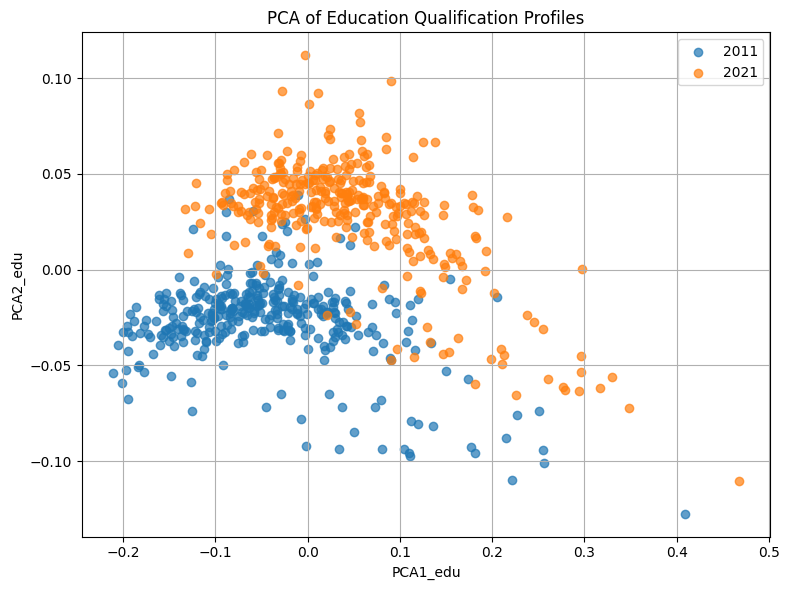

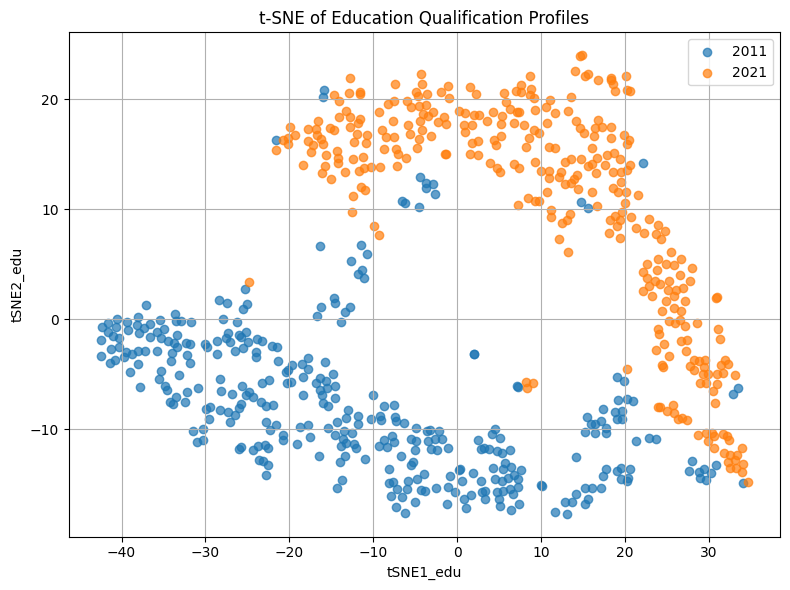

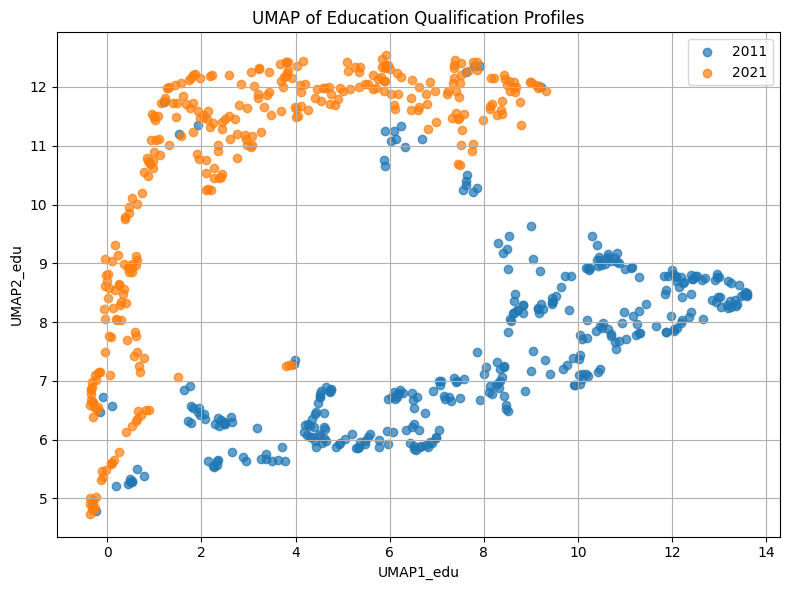

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# Load combined education data in long format 
df_edu = pd.read_csv('Highest_level_of_qualification_2011_2021.csv')

# Step 2: Pivot to wide format for PCA, t-SNE, and UMAP
edu_wide = df_edu.pivot_table(
    index=['Area code', 'Area name', 'Year'],
    columns='Qualification level',
    values='Number of persons',
    aggfunc='sum'
).reset_index()

# Normalize qualification counts to proportions (row-wise)
qual_cols = edu_wide.columns.difference(['Area code', 'Area name', 'Year'])
edu_wide[qual_cols] = edu_wide[qual_cols].div(edu_wide[qual_cols].sum(axis=1), axis=0)

# Fill missing values with 0 
edu_wide[qual_cols] = edu_wide[qual_cols].fillna(0)

# Applying PCA 
pca = PCA(n_components=2)
edu_wide[['PCA1_edu', 'PCA2_edu']] = pca.fit_transform(edu_wide[qual_cols])

# Applying t-SNE
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(edu_wide[qual_cols])
edu_wide['tSNE1_edu'], edu_wide['tSNE2_edu'] = tsne_result[:, 0], tsne_result[:, 1]

# Applying UMAP
umap_result = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(edu_wide[qual_cols])
edu_wide['UMAP1_edu'], edu_wide['UMAP2_edu'] = umap_result[:, 0], umap_result[:, 1]

# Save output with projections 
edu_wide.to_csv("Education_Projections_2011_2021.csv", index=False)
print("Saved: Education_Projections_2011_2021.csv")

# Define reusable plot function for PCA, t-SNE, and UMAP
def plot_embedding(df, x, y, title):
    plt.figure(figsize=(8, 6))
    for year in sorted(df['Year'].unique()):
        subset = df[df['Year'] == year]
        plt.scatter(subset[x], subset[y], label=str(year), alpha=0.7)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all 3 projections for education data
plot_embedding(edu_wide, 'PCA1_edu', 'PCA2_edu', 'PCA of Education Qualification Profiles')
plot_embedding(edu_wide, 'tSNE1_edu', 'tSNE2_edu', 't-SNE of Education Qualification Profiles')
plot_embedding(edu_wide, 'UMAP1_edu', 'UMAP2_edu', 'UMAP of Education Qualification Profiles')

### Economic Activity DataSet

In [ ]:
import pandas as pd

# Load and reshape 2011 dataset
df_2011 = pd.read_csv("/Users/parulnagar/Projects/2024_25/visual analytics/summative/2011/Economic_activity.csv")

# Define harmonization mapping (2011 → 2021 categories)
harmonize_2011_to_2021 = {
    'Economic Activity: Economically active: Employee: Part-time; measures: Value':
        'Economically active (excluding full-time students): In employment: Employee: Part-time',

    'Economic Activity: Economically active: Employee: Full-time; measures: Value':
        'Economically active (excluding full-time students): In employment: Employee: Full-time',

    'Economic Activity: Economically active: Self-employed with employees: Part-time; measures: Value':
        'Economically active (excluding full-time students): In employment: Self-employed with employees: Part-time',

    'Economic Activity: Economically active: Self-employed with employees: Full-time; measures: Value':
        'Economically active (excluding full-time students): In employment: Self-employed with employees: Full-time',

    'Economic Activity: Economically active: Self-employed without employees: Part-time; measures: Value':
        'Economically active (excluding full-time students): In employment: Self-employed without employees: Part-time',

    'Economic Activity: Economically active: Self-employed without employees: Full-time; measures: Value':
        'Economically active (excluding full-time students): In employment: Self-employed without employees: Full-time',

    'Economic Activity: Economically active: Unemployed; measures: Value':
        'Economically active (excluding full-time students): Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks',

    'Economic Activity: Economically active: Full-time student; measures: Value':
        'Economically active and a full-time student: Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks',

    'Economic Activity: Economically inactive: Retired; measures: Value':
        'Economically inactive: Retired',

    'Economic Activity: Economically inactive: Student (including full-time students); measures: Value':
        'Economically inactive: Student',

    'Economic Activity: Economically inactive: Looking after home or family; measures: Value':
        'Economically inactive: Looking after home or family',

    'Economic Activity: Economically inactive: Long-term sick or disabled; measures: Value':
        'Economically inactive: Long-term sick or disabled',

    'Economic Activity: Economically inactive: Other; measures: Value':
        'Economically inactive: Other'
}

# Filter and melt 2011 data
keep_cols = ['geography', 'geography code'] + list(harmonize_2011_to_2021.keys())
df_2011 = df_2011[keep_cols]

df_2011_long = df_2011.melt(
    id_vars=['geography', 'geography code'],
    var_name='Raw Category',
    value_name='Number of People'
)
df_2011_long['Economic Activity'] = df_2011_long['Raw Category'].map(harmonize_2011_to_2021)
df_2011_long = df_2011_long.dropna(subset=['Economic Activity'])
df_2011_long['Year'] = 2011

df_2011_long = df_2011_long.rename(columns={
    'geography': 'Area name',
    'geography code': 'Area code'
})[['Area code', 'Area name', 'Economic Activity', 'Number of People', 'Year']]

# Load and clean 2021 dataset
df_2021 = pd.read_csv("/Users/parulnagar/Projects/2024_25/visual analytics/summative/2021/Economic_activity_2021.csv")

df_2021 = df_2021.rename(columns={
    'Lower Tier Local Authorities Code': 'Area code',
    'Lower Tier Local Authorities': 'Area name',
    'Economic activity status (20 categories)': 'Economic Activity',
    'Observation': 'Number of People'
})
df_2021['Year'] = 2021
df_2021['Economic Activity'] = df_2021['Economic Activity'].str.strip()

# Harmonize excess categories in 2021 dataset
harmonize_2021 = {
    'Economically Inactive: Looking after home or family': 'Economically inactive: Looking after home or family',
    'Economically active and a full-time student: In employment: Employee: Part-time': 'Economically active (excluding full-time students): In employment: Employee: Part-time',
    'Economically active and a full-time student: In employment: Employee: Full-time': 'Economically active (excluding full-time students): In employment: Employee: Full-time',
    'Economically active and a full-time student: In employment: Self-employed with employees: Part-time': 'Economically active (excluding full-time students): In employment: Self-employed with employees: Part-time',
    'Economically active and a full-time student: In employment: Self-employed with employees: Full-time': 'Economically active (excluding full-time students): In employment: Self-employed with employees: Full-time',
    'Economically active and a full-time student: In employment: Self-employed without employees: Part-time': 'Economically active (excluding full-time students): In employment: Self-employed without employees: Part-time',
    'Economically active and a full-time student: In employment: Self-employed without employees: Full-time': 'Economically active (excluding full-time students): In employment: Self-employed without employees: Full-time',
    'Does not apply': None
}
df_2021['Economic Activity'] = df_2021['Economic Activity'].replace(harmonize_2021)
df_2021 = df_2021.dropna(subset=['Economic Activity'])

df_2021_cleaned = df_2021[['Area code', 'Area name', 'Economic Activity', 'Number of People', 'Year']]

# Combine both years 
df_combined = pd.concat([df_2011_long, df_2021_cleaned], ignore_index=True)

print(df_combined.head())

# Save the combined DataFrame to a CSV file
df_combined.to_csv("merged_economic_activity_2011_2021.csv", index=False)


   Area code       Area name  \
0  E06000005      Darlington   
1  E06000047   County Durham   
2  E06000001      Hartlepool   
3  E06000002   Middlesbrough   
4  E06000057  Northumberland   

                                   Economic Activity  Number of People  Year  
0  Economically active (excluding full-time stude...             11555  2011  
1  Economically active (excluding full-time stude...             50595  2011  
2  Economically active (excluding full-time stude...             10092  2011  
3  Economically active (excluding full-time stude...             15063  2011  
4  Economically active (excluding full-time stude...             34368  2011  


/Users/parulnagar/.pyenv/versions/3.12.7/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/parulnagar/.pyenv/versions/3.12.7/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


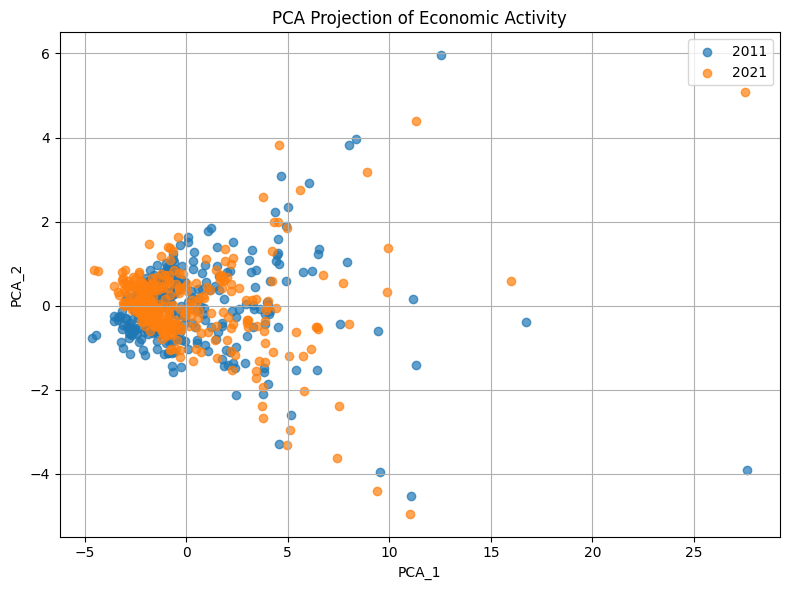

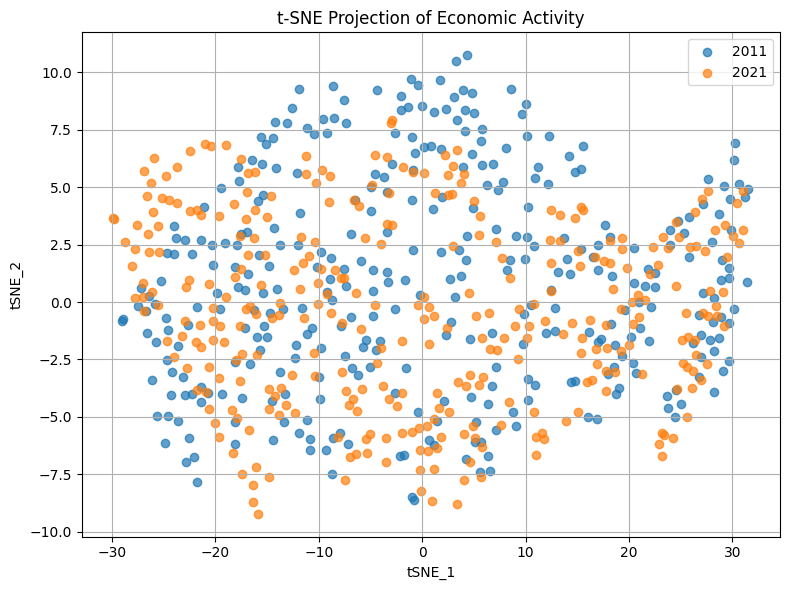

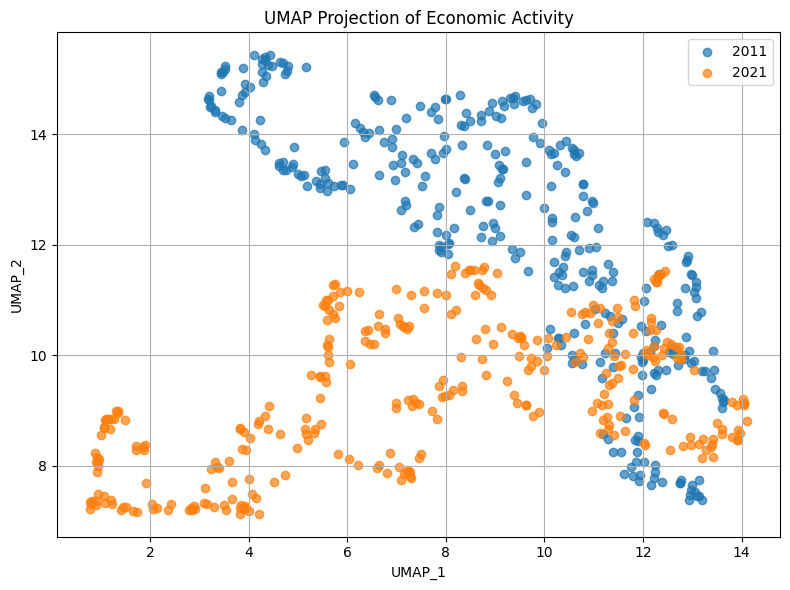

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Load merged dataset 
df = pd.read_csv("merged_economic_activity_2011_2021.csv")

# Pivot Area × Economic Activity matrix 
def create_matrix(df, year):
    df_year = df[df['Year'] == year]
    pivot = df_year.pivot_table(
        index=['Area code', 'Area name'],
        columns='Economic Activity',
        values='Number of People',
        fill_value=0
    )
    return pivot

matrix_2011 = create_matrix(df, 2011)
matrix_2021 = create_matrix(df, 2021)

# Standardize the data
scaler = StandardScaler()
X_2011 = scaler.fit_transform(matrix_2011)
X_2021 = scaler.fit_transform(matrix_2021)

# Run Dimensionality Reduction
pca_2011 = PCA(n_components=2).fit_transform(X_2011)
pca_2021 = PCA(n_components=2).fit_transform(X_2021)

tsne_2011 = TSNE(n_components=2, random_state=42).fit_transform(X_2011)
tsne_2021 = TSNE(n_components=2, random_state=42).fit_transform(X_2021)

umap_2011 = umap.UMAP(n_components=2, random_state=42).fit_transform(X_2011)
umap_2021 = umap.UMAP(n_components=2, random_state=42).fit_transform(X_2021)

# Combine projections into unified DataFrame 
def build_df(coords, index, method, year):
    df_proj = pd.DataFrame(coords, columns=[f"{method}_1", f"{method}_2"])
    df_proj['Area code'] = index.get_level_values(0).values
    df_proj['Area name'] = index.get_level_values(1).values
    df_proj['Year'] = year
    return df_proj

# Build and merge dataframes for 2011 and 2021
df_2011 = build_df(pca_2011, matrix_2011.index, 'PCA', 2011)
df_2011[['tSNE_1', 'tSNE_2']] = tsne_2011
df_2011[['UMAP_1', 'UMAP_2']] = umap_2011

df_2021 = build_df(pca_2021, matrix_2021.index, 'PCA', 2021)
df_2021[['tSNE_1', 'tSNE_2']] = tsne_2021
df_2021[['UMAP_1', 'UMAP_2']] = umap_2021

# Combine 2011 and 2021 dataframes
merged_df = pd.concat([df_2011, df_2021], ignore_index=True)

# Export to CSV 
merged_df.to_csv("Merged_economic_activity_projection.csv", index=False)

# Plot each method
def plot_projection(df, x, y, title):
    plt.figure(figsize=(8,6))
    for year in sorted(df['Year'].unique()):
        subset = df[df['Year'] == year]
        plt.scatter(subset[x], subset[y], label=str(year), alpha=0.7)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize all three projections
plot_projection(merged_df, 'PCA_1', 'PCA_2', 'PCA Projection of Economic Activity')
plot_projection(merged_df, 'tSNE_1', 'tSNE_2', 't-SNE Projection of Economic Activity')
plot_projection(merged_df, 'UMAP_1', 'UMAP_2', 'UMAP Projection of Economic Activity')






### HouseHold Depreviation Data

In [ ]:
import pandas as pd

### Load and Process 2011 Deprivation Data (wide to long) ###
file_2011 = "/Users/parulnagar/Projects/2024_25/visual analytics/summative/2011/Households_by_deprivation_dimensions.xls"
df_2011_raw = pd.read_excel(file_2011, sheet_name="QS119EW_Numbers", skiprows=10)

# Keep only LA-level rows 
df_2011_raw = df_2011_raw[df_2011_raw['Area code'].astype(str).str.match(r"E06|E07|E08|E09|W06|W07|W08|W09")]

# Select required columns 
df_depriv_2011 = df_2011_raw[[
    'Area code', 'Area name',
    'Household is not deprived in any dimension',
    'Household is deprived in 1 dimension',
    'Household is deprived in 2 dimensions',
    'Household is deprived in 3 dimensions',
    'Household is deprived in 4 dimensions'
]].copy()

# Clean numeric values 
depriv_cols = df_depriv_2011.columns[2:]
for col in depriv_cols:
    df_depriv_2011[col] = (
        df_depriv_2011[col].astype(str)
        .str.replace(",", "", regex=False)
        .replace('nan', 0)
        .astype(float)
        .astype(int)
    )

# Reshape to long format 
df_depriv_2011_long = df_depriv_2011.melt(
    id_vars=['Area code', 'Area name'],
    value_vars=depriv_cols,
    var_name='Deprivation level',
    value_name='Number of households'
)
df_depriv_2011_long['Year'] = 2011

### --- Load and Process 2021 Deprivation Data (already long format) --- ###
df_depriv_2021 = pd.read_csv("/Users/parulnagar/Projects/2024_25/visual analytics/summative/2021/Household_deprivation_2021.csv")

# Rename columns to match 2011 dataset
df_depriv_2021 = df_depriv_2021.rename(columns={
    'Lower Tier Local Authorities Code': 'Area code',
    'Lower Tier Local Authorities': 'Area name',
    'Household deprivation (6 categories)': 'Deprivation level',
    'Observation': 'Number of households'
})

# Drop "Does not apply" rows
df_depriv_2021 = df_depriv_2021[df_depriv_2021['Deprivation level'] != 'Does not apply']

# Harmonize labels to match 2011 
label_mapping = {
    'Household is not deprived in any dimension': 'Household is not deprived in any dimension',
    'Household is deprived in one dimension': 'Household is deprived in 1 dimension',
    'Household is deprived in two dimensions': 'Household is deprived in 2 dimensions',
    'Household is deprived in three dimensions': 'Household is deprived in 3 dimensions',
    'Household is deprived in four dimensions': 'Household is deprived in 4 dimensions'
}
df_depriv_2021['Deprivation level'] = df_depriv_2021['Deprivation level'].map(label_mapping)

# Add year column 
df_depriv_2021['Year'] = 2021

# Finalize column order 
df_depriv_2021 = df_depriv_2021[['Year', 'Area code', 'Area name', 'Deprivation level', 'Number of households']]

### Merge 2011 and 2021 ###
df_depriv_combined = pd.concat([df_depriv_2011_long, df_depriv_2021], ignore_index=True)

# Display result
print("Combined shape:", df_depriv_combined.shape)
print(df_depriv_combined.head())

# Save the combined DataFrame to a CSV file
df_depriv_combined.to_csv('Deprivation_combined_2011_2021.csv', index=False)



Combined shape: (3395, 5)
   Area code Area name                           Deprivation level  \
0  E06000047       NaN  Household is not deprived in any dimension   
1  E06000005       NaN  Household is not deprived in any dimension   
2  E06000001       NaN  Household is not deprived in any dimension   
3  E06000002       NaN  Household is not deprived in any dimension   
4  E06000048       NaN  Household is not deprived in any dimension   

   Number of households  Year  
0                 87986  2011  
1                 20184  2011  
2                 14351  2011  
3                 19729  2011  
4                 60451  2011  


/Users/parulnagar/.pyenv/versions/3.12.7/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: Household_deprivation_projections.csv


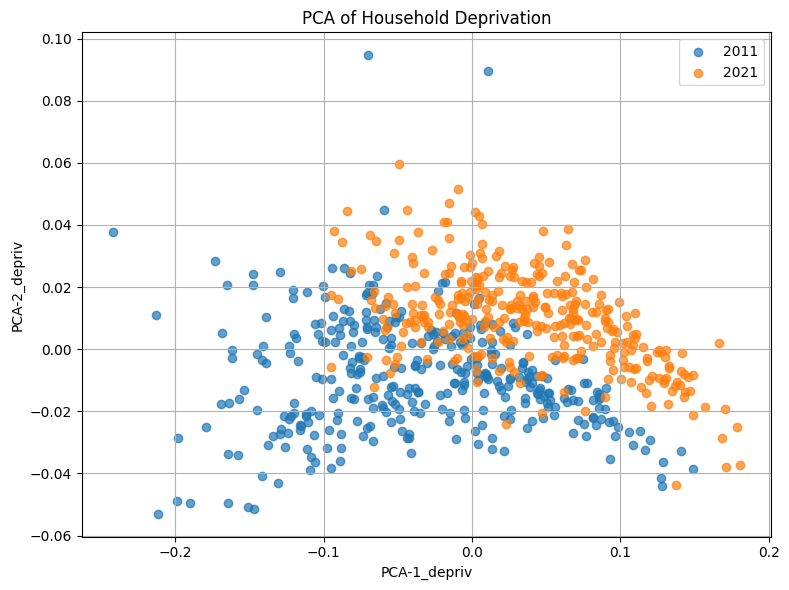

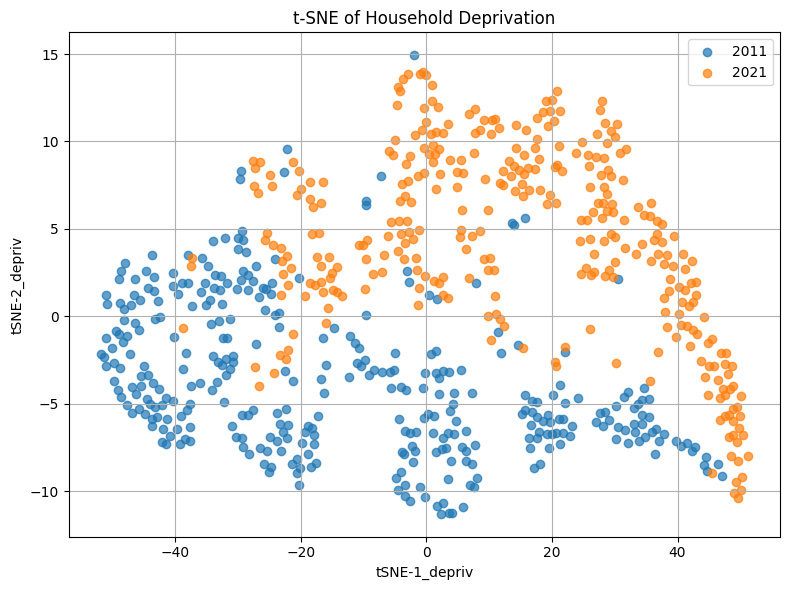

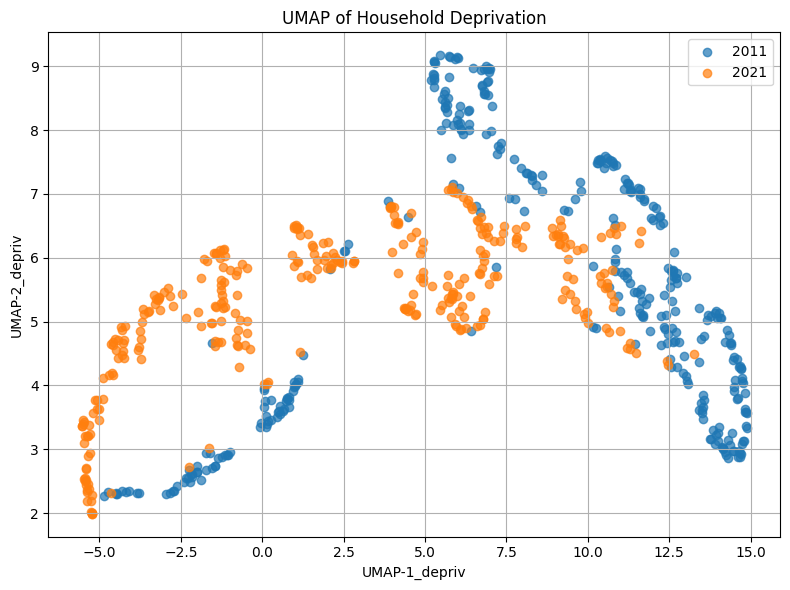

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt


df_depriv_combined['Deprivation level'] = df_depriv_combined['Deprivation level'] + '_depriv'

# Pivot to wide format 
df_wide = df_depriv_combined.pivot_table(
    index=['Year', 'Area code',],
    columns='Deprivation level',
    values='Number of households',
    aggfunc='sum'
).reset_index()

# Fill NaNs with 0
depriv_cols = [col for col in df_wide.columns if col.endswith('_depriv')]
df_wide[depriv_cols] = df_wide[depriv_cols].fillna(0)

# Normalize to proportions row-wise
df_wide[depriv_cols] = df_wide[depriv_cols].div(df_wide[depriv_cols].sum(axis=1), axis=0)

# Applying PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_wide[depriv_cols])
df_wide['PCA-1_depriv'], df_wide['PCA-2_depriv'] = pca_result[:, 0], pca_result[:, 1]

# Applying t-SNE
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(df_wide[depriv_cols])
df_wide['tSNE-1_depriv'], df_wide['tSNE-2_depriv'] = tsne_result[:, 0], tsne_result[:, 1]

# Applying UMAP
umap_result = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(df_wide[depriv_cols])
df_wide['UMAP-1_depriv'], df_wide['UMAP-2_depriv'] = umap_result[:, 0], umap_result[:, 1]

# Save projections
df_wide.to_csv("Household_deprivation_projections.csv", index=False)
print("Saved: Household_deprivation_projections.csv")

# Plotting function for PCA, t-SNE, and UMAP
def plot_embedding(df, x, y, title):
    plt.figure(figsize=(8, 6))
    for year in sorted(df['Year'].unique()):
        subset = df[df['Year'] == year]
        plt.scatter(subset[x], subset[y], label=str(year), alpha=0.7)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all three projections for deprivation data
plot_embedding(df_wide, 'PCA-1_depriv', 'PCA-2_depriv', 'PCA of Household Deprivation')
plot_embedding(df_wide, 'tSNE-1_depriv', 'tSNE-2_depriv', 't-SNE of Household Deprivation')
plot_embedding(df_wide, 'UMAP-1_depriv', 'UMAP-2_depriv', 'UMAP of Household Deprivation')

### Unpaid Care Provision Dataset

In [ ]:
import pandas as pd

### Load and Process 2011 Unpaid Care (wide to long)

df_care_2011 = pd.read_csv("/Users/parulnagar/Projects/2024_25/visual analytics/summative/2011/Provision_of_unpaid_care.csv")

# Rename for consistency 
df_care_2011 = df_care_2011.rename(columns={
    'date': 'Year',
    'geography': 'Area name',
    'geography code': 'Area code',
    'Care Provision: Provides no unpaid care; measures: Value': 'Provides no unpaid care',
    'Care Provision: Provides 1 to 19 hours unpaid care a week; measures: Value': 'Provides 1 to 19 hours',
    'Care Provision: Provides 20 to 49 hours unpaid care a week; measures: Value': 'Provides 20 to 49 hours',
    'Care Provision: Provides 50 or more hours unpaid care a week; measures: Value': 'Provides 50+ hours'
})

# Keep only required columns 
care_2011_cols = [
    'Area code', 'Area name', 'Year',
    'Provides no unpaid care',
    'Provides 1 to 19 hours',
    'Provides 20 to 49 hours',
    'Provides 50+ hours'
]
df_care_2011 = df_care_2011[care_2011_cols]

# Convert numbers to int 
for col in care_2011_cols[3:]:
    df_care_2011[col] = df_care_2011[col].astype(str).str.replace(",", "").astype(int)

# Reshape to long format 
df_care_2011_long = df_care_2011.melt(
    id_vars=['Area code', 'Area name', 'Year'],
    value_vars=care_2011_cols[3:],
    var_name='Unpaid care category',
    value_name='Number of people'
)

### Load and Process 2021 Unpaid Care

df_care_2021 = pd.read_csv("/Users/parulnagar/Projects/2024_25/visual analytics/summative/2021/Unpaid_care.csv")

# Rename columns for consistency 
df_care_2021 = df_care_2021.rename(columns={
    'Lower tier local authorities Code': 'Area code',
    'Lower tier local authorities': 'Area name',
    'Unpaid care (7 categories)': 'Unpaid care category'
})

# Drop 'Does not apply' rows
df_care_2021 = df_care_2021[df_care_2021['Unpaid care category'] != 'Does not apply']

# Aggregate (if there are multiple socio-demographic breakdowns) 
df_care_2021_agg = df_care_2021.groupby(
    ['Area code', 'Area name', 'Unpaid care category'], as_index=False
)['Observation'].sum()

df_care_2021_agg['Year'] = 2021
df_care_2021_agg = df_care_2021_agg.rename(columns={'Observation': 'Number of people'})

# Map detailed 2021 categories to simpler 2011-aligned ones 
label_map = {
    'Provides no unpaid care': 'Provides no unpaid care',
    'Provides 9 hours or less unpaid care a week': 'Provides 1 to 19 hours',
    'Provides 10 to 19 hours unpaid care a week': 'Provides 1 to 19 hours',
    'Provides 20 to 34 hours unpaid care a week': 'Provides 20 to 49 hours',
    'Provides 35 to 49 hours unpaid care a week': 'Provides 20 to 49 hours',
    'Provides 50 or more hours unpaid care a week': 'Provides 50+ hours'
}
df_care_2021_agg['Unpaid care category'] = df_care_2021_agg['Unpaid care category'].map(label_map)

# Re-aggregate after mapping 
df_care_2021_final = df_care_2021_agg.groupby(
    ['Area code', 'Area name', 'Unpaid care category', 'Year'], as_index=False
)['Number of people'].sum()

### Merge 2011 and 2021 Unpaid Care 

df_care_combined = pd.concat([df_care_2011_long, df_care_2021_final], ignore_index=True)

# Sort and display 
df_care_combined = df_care_combined.sort_values(by=['Area code', 'Year', 'Unpaid care category'])

# Save the combined DataFrame to a CSV file
df_care_combined.to_csv("Unpaid_Care_Combined_2011_2021.csv", index=False)
print("Saved: Unpaid_Care_Combined_2011_2021.csv")

# Quick check 
print(df_care_combined.head())


Saved: Unpaid_Care_Combined_2011_2021.csv
      Area code   Area name  Year     Unpaid care category  Number of people
350   E06000001  Hartlepool  2011   Provides 1 to 19 hours              5325
698   E06000001  Hartlepool  2011  Provides 20 to 49 hours              1555
1046  E06000001  Hartlepool  2011       Provides 50+ hours              3044
2     E06000001  Hartlepool  2011  Provides no unpaid care             82104
1392  E06000001  Hartlepool  2021   Provides 1 to 19 hours              3660


/Users/parulnagar/.pyenv/versions/3.12.7/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: Care_Projections_2011_2021.csv


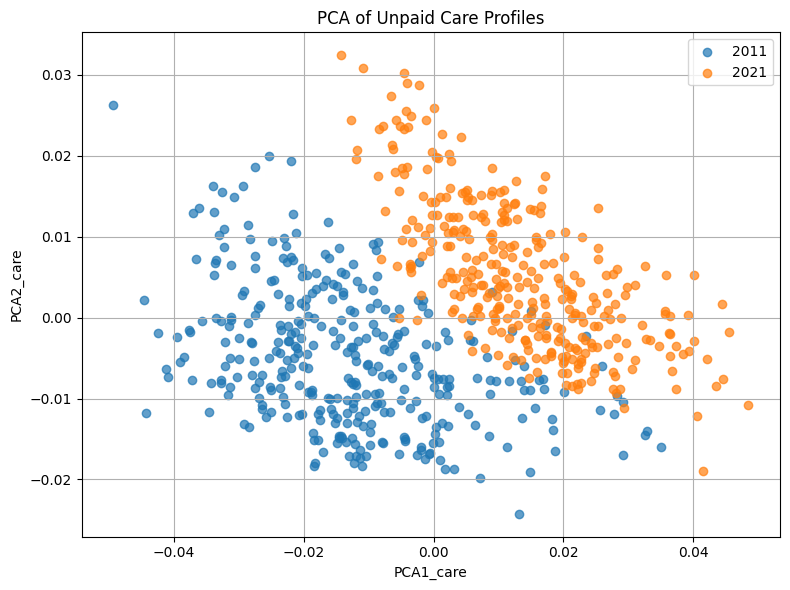

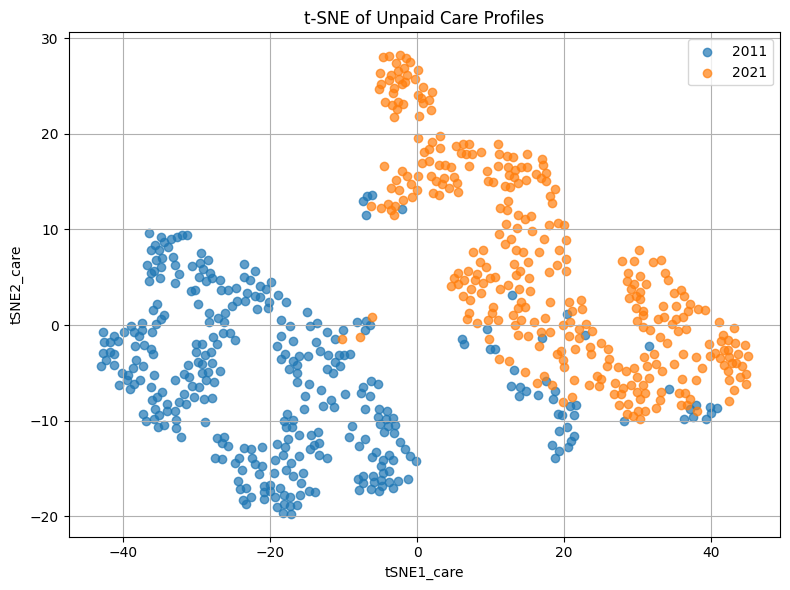

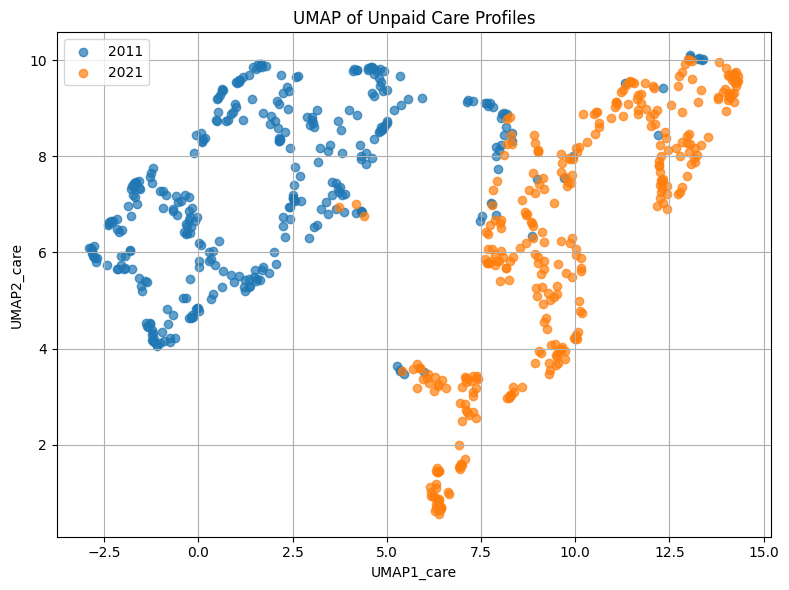

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# Load combined care data 
df_care = pd.read_csv("Unpaid_Care_Combined_2011_2021.csv")

# Pivot to wide format (one row per LA per year, columns = care categories) 
care_wide = df_care.pivot_table(
    index=['Area code', 'Area name', 'Year'],
    columns='Unpaid care category',
    values='Number of people',
    aggfunc='sum'
).reset_index()

# Normalize care counts to proportions (row-wise) 
care_cols = care_wide.columns.difference(['Area code', 'Area name', 'Year'])
care_wide[care_cols] = care_wide[care_cols].div(care_wide[care_cols].sum(axis=1), axis=0)

# Fill any missing values (e.g., if a care category was missing for an area) 
care_wide[care_cols] = care_wide[care_cols].fillna(0)

# Apply PCA 
pca = PCA(n_components=2)
care_wide[['PCA1_care', 'PCA2_care']] = pca.fit_transform(care_wide[care_cols])

# Apply t-SNE 
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(care_wide[care_cols])
care_wide['tSNE1_care'], care_wide['tSNE2_care'] = tsne_result[:, 0], tsne_result[:, 1]

# Apply UMAP
umap_result = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(care_wide[care_cols])
care_wide['UMAP1_care'], care_wide['UMAP2_care'] = umap_result[:, 0], umap_result[:, 1]

# Save output with projections
care_wide.to_csv("Care_Projections_2011_2021.csv", index=False)
print("Saved: Care_Projections_2011_2021.csv")

# Define reusable plot function for PCA, t-SNE, and UMAP
def plot_embedding(df, x, y, title):
    plt.figure(figsize=(8, 6))
    for year in sorted(df['Year'].unique()):
        subset = df[df['Year'] == year]
        plt.scatter(subset[x], subset[y], label=str(year), alpha=0.7)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all 3 projections for care data
plot_embedding(care_wide, 'PCA1_care', 'PCA2_care', 'PCA of Unpaid Care Profiles')
plot_embedding(care_wide, 'tSNE1_care', 'tSNE2_care', 't-SNE of Unpaid Care Profiles')
plot_embedding(care_wide, 'UMAP1_care', 'UMAP2_care', 'UMAP of Unpaid Care Profiles')


### Bayesian Ridge Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error

# Load data
health_df = pd.read_csv("Health_Projections_2011_2021.csv")

# Define health outcome columns 
health_categories = ['Very good health', 'Good health', 'Fair health', 'Bad health', 'Very bad health']

# Split into 2011 and 2021 data 
health_2011 = health_df[health_df['Year'] == 2011].set_index('Area code')
health_2021 = health_df[health_df['Year'] == 2021].set_index('Area code')

# Align Area codes that exist in both years 
common_codes = list(set(health_2011.index) & set(health_2021.index))
health_2011 = health_2011.loc[common_codes].sort_index()
health_2021 = health_2021.loc[common_codes].sort_index()

X_2011 = health_2011[health_categories]
X_2021 = health_2021[health_categories]

# Linear extrapolation to 2030 
X_2030 = X_2021 + (X_2021 - X_2011) * (9 / 10)

# Train separate models for each category and predict 2030 
predictions_2030 = pd.DataFrame(index=X_2030.index)
results = {}

for col in health_categories:
    # Train Bayesian Ridge model
    model = BayesianRidge()
    model.fit(X_2011[[col]], X_2021[col])

    # Predict for 2030 
    y_pred_2030 = model.predict(X_2030[[col]])
    predictions_2030[f"Predicted {col}"] = y_pred_2030

    # Evaluate on 2021 prediction from 2011
    y_pred_2021 = model.predict(X_2011[[col]])
    r2 = r2_score(X_2021[col], y_pred_2021)
    mse = mean_squared_error(X_2021[col], y_pred_2021)
    results[col] = {'R2_2021': r2, 'MSE_2021': mse}

# Clean results
# Remove negatives and normalize rows to sum to 1
pred_array = np.maximum(predictions_2030.values, 0)
pred_array = pred_array / pred_array.sum(axis=1, keepdims=True)
predictions_2030.loc[:, :] = pred_array

# Combine 2011, 2021, and 2030 data for comparison 

# Prepare 2011 and 2021 data for export
X_2011 = X_2011.reset_index()
X_2011.columns = ['Area code'] + [f"2011 {col}" for col in health_categories]

X_2021 = X_2021.reset_index()
X_2021.columns = ['Area code'] + [f"2021 {col}" for col in health_categories]

# Reset index before renaming predictions
predictions_2030 = predictions_2030.reset_index()
predictions_2030.columns = ['Area code'] + [f"2030 {col}" for col in health_categories]

# Merge all three datasets on Area code 
df_combined = X_2011.merge(X_2021, on='Area code').merge(predictions_2030, on='Area code')

# Save to CSV for Tableau
df_combined.to_csv("Health_Univariate_Prediction_2030.csv", index=False)
print("Saved: Health_Univariate_Prediction_2030.csv")

# Show model evaluation results
print("\nModel performance (predicting 2021 from 2011):")
for col in health_categories:
    print(f"{col:>20} → R²: {results[col]['R2_2021']:.3f}, MSE: {results[col]['MSE_2021']:.6f}")


Saved: Health_Univariate_Prediction_2030.csv

Model performance (predicting 2021 from 2011):
    Very good health → R²: 0.909, MSE: 0.000145
         Good health → R²: 0.775, MSE: 0.000060
         Fair health → R²: 0.943, MSE: 0.000021
          Bad health → R²: 0.941, MSE: 0.000006
     Very bad health → R²: 0.933, MSE: 0.000001
